In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [6]:
datatrain = pd.read_csv('data/yeast/yeast-train.csv')
datatest = pd.read_csv('data/yeast/yeast-test.csv')

datatrain.loc[datatrain['Class1'] =="b'0'", 'Class1'] = 0
datatrain.loc[datatrain['Class1'] =="b'1'", 'Class1'] = 1
datatest.loc[datatest['Class1'] =="b'0'", 'Class1'] = 0
datatest.loc[datatest['Class1'] =="b'1'", 'Class1'] = 1

dataset = pd.concat([datatrain, datatest], ignore_index=True)

In [21]:
X = dataset.drop(['Class1','Class2','Class3','Class4','Class5','Class6','Class7','Class8','Class9','Class10','Class11','Class12','Class13','Class14'],axis=1)
y = dataset['Class1']

In [22]:
X.shape

(2417, 103)

In [9]:
y=y.values

In [23]:
scaler = StandardScaler()
scaler.fit(X)
scaled_dataset = scaler.transform(X)

In [44]:
lda = LDA()  
lda.fit(scaled_dataset,y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [45]:
lda_dataset = lda.transform(scaled_dataset)

In [46]:
lda_dataset.shape

(2417, 1)

In [47]:
per_var = np.round(lda.explained_variance_ratio_*100, decimals=1)

In [48]:
labels = ['PC'+str(i) for i in range(1,len(per_var)+1)]

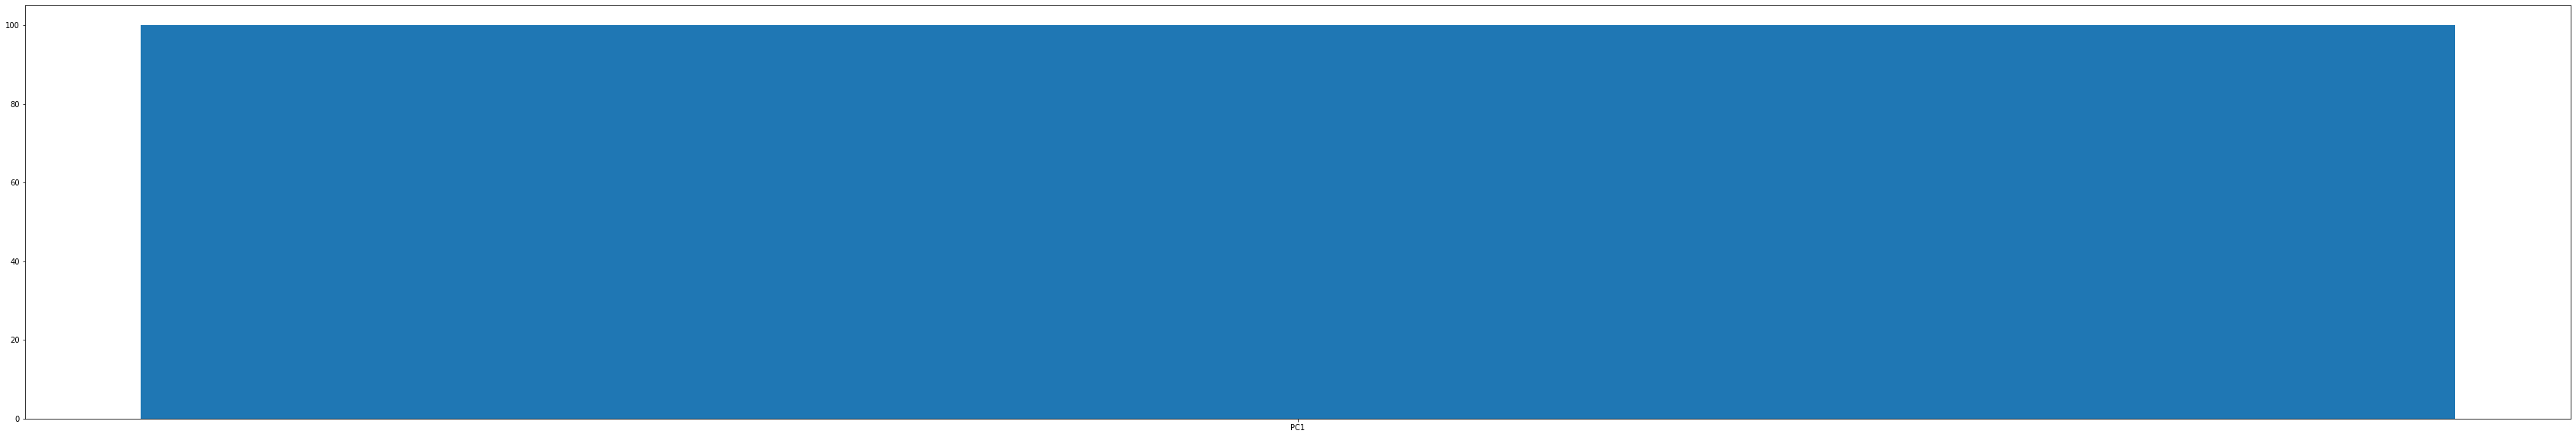

In [49]:
plt.subplots(figsize=(60,10))
plt.bar(x=range(1,len(per_var)+1), height=per_var,tick_label=labels)
plt.show()

In [51]:
random.seed(0)
X_train,X_test, y_train,y_test =train_test_split(lda_dataset,y,test_size=0.2,random_state=0)
print(X_train.shape)
print(X_test.shape)

(1933, 1)
(484, 1)


In [52]:
a = [el/100 for el in range(1,101) ]


In [53]:
mxa=0
for i in a:
    xgbclassifier = XGBClassifier(learning_rate=i)
    xgbclassifier.fit(X_train, y_train)
    y_pred = xgbclassifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))
    if accuracy>mxa:
        mxa=accuracy
        print(mxa,i)

0.8099173553719008 0.01
0.8140495867768595 0.04
0.8161157024793388 0.12
0.8181818181818182 0.15


In [54]:
from sklearn.svm import SVC

svmclassifier = SVC(kernel='linear' ,random_state=0)
svmclassifier.fit(X_train,y_train)
y_pred_svm = svmclassifier.predict(X_test)

cm = confusion_matrix(y_test,y_pred_svm)
print(cm)
accuracy=accuracy_score(y_test, y_pred_svm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[[313  17]
 [ 78  76]]
Accuracy: 80.37%


In [55]:
from sklearn.ensemble import RandomForestClassifier
mxa = 0
for i in range(1,51):
    rfclassifier = RandomForestClassifier(n_estimators=i*5,criterion='entropy',random_state=0)
    rfclassifier.fit(X_train,y_train)
    y_pred_randForest = rfclassifier.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred_randForest)
    if accuracy>mxa:
        mxa=accuracy
        print(accuracy,(i*5))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.7252066115702479 5
0.731404958677686 10
Accuracy: 71.28%


In [56]:
# Packages for training model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization

# Packages for explanation
from keras import backend as K
from keras.models import Model
from deepexplain.tensorflow import DeepExplain
from IPython.display import display, HTML
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [57]:
sgdOptimizer = 'adam'
lossFun='categorical_crossentropy'
finalLayerActivation = 'softmax'
batchSize=25
numEpochs = 500
nb_classes = 2
inputDim=1

In [58]:
trainY=np_utils.to_categorical(y_train, num_classes = nb_classes)
testY=np_utils.to_categorical(y_test, num_classes = nb_classes)

In [59]:
model = Sequential()
model.add(BatchNormalization(input_shape=(inputDim,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nb_classes, activation=finalLayerActivation))
model.compile(loss=lossFun, optimizer=sgdOptimizer, metrics=["accuracy"])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 1)                 4         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)  

In [64]:
model.fit(X_train,trainY,validation_data=(X_test,testY) ,batch_size=batchSize, epochs=numEpochs, verbose=1)
trainScore = model.evaluate(X_train,trainY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], trainScore[1]*100))
testScore = model.evaluate(X_test,testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], testScore[1]*100))

Train on 1933 samples, validate on 484 samples
Epoch 1/500
1933/1933 [==============================] - 1s 281us/step - loss: 0.4766 - acc: 0.7874 - val_loss: 0.4728 - val_acc: 0.8037
Epoch 2/500
1933/1933 [==============================] - 1s 263us/step - loss: 0.4874 - acc: 0.7879 - val_loss: 0.4685 - val_acc: 0.8099
Epoch 3/500
1933/1933 [==============================] - 0s 255us/step - loss: 0.4769 - acc: 0.7946 - val_loss: 0.4762 - val_acc: 0.7996
Epoch 4/500
1933/1933 [==============================] - 1s 275us/step - loss: 0.4769 - acc: 0.7822 - val_loss: 0.4732 - val_acc: 0.8058
Epoch 5/500
1933/1933 [==============================] - 1s 285us/step - loss: 0.4785 - acc: 0.7920 - val_loss: 0.4745 - val_acc: 0.8058
Epoch 6/500
1933/1933 [==============================] - 1s 281us/step - loss: 0.4812 - acc: 0.7889 - val_loss: 0.4761 - val_acc: 0.7934
Epoch 7/500
1933/1933 [==============================] - 1s 282us/step - loss: 0.4915 - acc: 0.7739 - val_loss: 0.4757 - val_acc: 0

1933/1933 [==============================] - 1s 262us/step - loss: 0.4784 - acc: 0.7863 - val_loss: 0.4704 - val_acc: 0.8037
Epoch 61/500
1933/1933 [==============================] - 0s 247us/step - loss: 0.4887 - acc: 0.7858 - val_loss: 0.4728 - val_acc: 0.8058
Epoch 62/500
1933/1933 [==============================] - 0s 253us/step - loss: 0.4751 - acc: 0.7858 - val_loss: 0.4698 - val_acc: 0.8037
Epoch 63/500
1933/1933 [==============================] - 0s 253us/step - loss: 0.4860 - acc: 0.7905 - val_loss: 0.4708 - val_acc: 0.8037
Epoch 64/500
1933/1933 [==============================] - 0s 250us/step - loss: 0.4852 - acc: 0.7843 - val_loss: 0.4691 - val_acc: 0.8037
Epoch 65/500
1933/1933 [==============================] - 0s 249us/step - loss: 0.4820 - acc: 0.7889 - val_loss: 0.4750 - val_acc: 0.8140
Epoch 66/500
1933/1933 [==============================] - 0s 239us/step - loss: 0.4869 - acc: 0.7843 - val_loss: 0.4723 - val_acc: 0.8037
Epoch 67/500
1933/1933 [=======================

1933/1933 [==============================] - 0s 249us/step - loss: 0.4825 - acc: 0.7863 - val_loss: 0.4683 - val_acc: 0.8079
Epoch 120/500
1933/1933 [==============================] - 0s 245us/step - loss: 0.4818 - acc: 0.7843 - val_loss: 0.4732 - val_acc: 0.7893
Epoch 121/500
1933/1933 [==============================] - 0s 247us/step - loss: 0.4771 - acc: 0.7822 - val_loss: 0.4675 - val_acc: 0.8058
Epoch 122/500
1933/1933 [==============================] - 0s 236us/step - loss: 0.4813 - acc: 0.7874 - val_loss: 0.4692 - val_acc: 0.8058
Epoch 123/500
1933/1933 [==============================] - 0s 246us/step - loss: 0.4753 - acc: 0.7832 - val_loss: 0.4683 - val_acc: 0.8058
Epoch 124/500
1933/1933 [==============================] - 0s 251us/step - loss: 0.4873 - acc: 0.7874 - val_loss: 0.4693 - val_acc: 0.7996
Epoch 125/500
1933/1933 [==============================] - 0s 254us/step - loss: 0.4891 - acc: 0.7848 - val_loss: 0.4680 - val_acc: 0.7955
Epoch 126/500
1933/1933 [================

1933/1933 [==============================] - 1s 285us/step - loss: 0.4831 - acc: 0.7879 - val_loss: 0.4703 - val_acc: 0.8058
Epoch 179/500
1933/1933 [==============================] - 0s 254us/step - loss: 0.4943 - acc: 0.7910 - val_loss: 0.4767 - val_acc: 0.8017
Epoch 180/500
1933/1933 [==============================] - 0s 257us/step - loss: 0.4933 - acc: 0.7724 - val_loss: 0.4724 - val_acc: 0.8099
Epoch 181/500
1933/1933 [==============================] - 0s 247us/step - loss: 0.4834 - acc: 0.7931 - val_loss: 0.4694 - val_acc: 0.8037
Epoch 182/500
1933/1933 [==============================] - 1s 266us/step - loss: 0.4911 - acc: 0.7770 - val_loss: 0.4725 - val_acc: 0.8037
Epoch 183/500
1933/1933 [==============================] - 0s 257us/step - loss: 0.4721 - acc: 0.7982 - val_loss: 0.4685 - val_acc: 0.8058
Epoch 184/500
1933/1933 [==============================] - 0s 246us/step - loss: 0.4726 - acc: 0.7941 - val_loss: 0.4718 - val_acc: 0.8079
Epoch 185/500
1933/1933 [================

1933/1933 [==============================] - 0s 247us/step - loss: 0.4847 - acc: 0.7894 - val_loss: 0.4742 - val_acc: 0.8058
Epoch 238/500
1933/1933 [==============================] - 0s 255us/step - loss: 0.4826 - acc: 0.7832 - val_loss: 0.4709 - val_acc: 0.8099
Epoch 239/500
1933/1933 [==============================] - 0s 245us/step - loss: 0.4812 - acc: 0.7838 - val_loss: 0.4710 - val_acc: 0.8037
Epoch 240/500
1933/1933 [==============================] - 0s 255us/step - loss: 0.4896 - acc: 0.7755 - val_loss: 0.4729 - val_acc: 0.8079
Epoch 241/500
1933/1933 [==============================] - 1s 265us/step - loss: 0.4855 - acc: 0.7822 - val_loss: 0.4768 - val_acc: 0.8017
Epoch 242/500
1933/1933 [==============================] - 1s 273us/step - loss: 0.4778 - acc: 0.7858 - val_loss: 0.4744 - val_acc: 0.8120
Epoch 243/500
1933/1933 [==============================] - 1s 286us/step - loss: 0.4814 - acc: 0.7817 - val_loss: 0.4757 - val_acc: 0.8079
Epoch 244/500
1933/1933 [================

1933/1933 [==============================] - 1s 265us/step - loss: 0.4778 - acc: 0.7879 - val_loss: 0.4748 - val_acc: 0.7996
Epoch 297/500
1933/1933 [==============================] - 0s 243us/step - loss: 0.4922 - acc: 0.7905 - val_loss: 0.4776 - val_acc: 0.7913
Epoch 298/500
1933/1933 [==============================] - 1s 280us/step - loss: 0.4861 - acc: 0.7879 - val_loss: 0.4763 - val_acc: 0.7893
Epoch 299/500
1933/1933 [==============================] - 0s 246us/step - loss: 0.4895 - acc: 0.7832 - val_loss: 0.4760 - val_acc: 0.7934
Epoch 300/500
1933/1933 [==============================] - 0s 252us/step - loss: 0.4946 - acc: 0.7750 - val_loss: 0.4766 - val_acc: 0.7934
Epoch 301/500
1933/1933 [==============================] - 0s 256us/step - loss: 0.4812 - acc: 0.7843 - val_loss: 0.4739 - val_acc: 0.8017
Epoch 302/500
1933/1933 [==============================] - 0s 245us/step - loss: 0.4907 - acc: 0.7744 - val_loss: 0.4812 - val_acc: 0.7851
Epoch 303/500
1933/1933 [================

1933/1933 [==============================] - 0s 245us/step - loss: 0.4813 - acc: 0.7822 - val_loss: 0.4716 - val_acc: 0.8099
Epoch 356/500
1933/1933 [==============================] - 0s 253us/step - loss: 0.4889 - acc: 0.7920 - val_loss: 0.4760 - val_acc: 0.7934
Epoch 357/500
1933/1933 [==============================] - 0s 258us/step - loss: 0.4889 - acc: 0.7863 - val_loss: 0.4754 - val_acc: 0.8037
Epoch 358/500
1933/1933 [==============================] - 0s 242us/step - loss: 0.4822 - acc: 0.7801 - val_loss: 0.4690 - val_acc: 0.8079
Epoch 359/500
1933/1933 [==============================] - 0s 248us/step - loss: 0.4695 - acc: 0.7884 - val_loss: 0.4697 - val_acc: 0.8058
Epoch 360/500
1933/1933 [==============================] - 0s 249us/step - loss: 0.4785 - acc: 0.7848 - val_loss: 0.4687 - val_acc: 0.8079
Epoch 361/500
1933/1933 [==============================] - 0s 248us/step - loss: 0.4934 - acc: 0.7765 - val_loss: 0.4786 - val_acc: 0.7913
Epoch 362/500
1933/1933 [================

1933/1933 [==============================] - 1s 261us/step - loss: 0.4834 - acc: 0.7838 - val_loss: 0.4751 - val_acc: 0.7955
Epoch 415/500
1933/1933 [==============================] - 0s 243us/step - loss: 0.4697 - acc: 0.7879 - val_loss: 0.4712 - val_acc: 0.8037
Epoch 416/500
1933/1933 [==============================] - 0s 247us/step - loss: 0.4885 - acc: 0.7832 - val_loss: 0.4737 - val_acc: 0.7934
Epoch 417/500
1933/1933 [==============================] - 0s 255us/step - loss: 0.4834 - acc: 0.7832 - val_loss: 0.4706 - val_acc: 0.8017
Epoch 418/500
1933/1933 [==============================] - 0s 254us/step - loss: 0.4920 - acc: 0.7667 - val_loss: 0.4740 - val_acc: 0.8037
Epoch 419/500
1933/1933 [==============================] - 0s 252us/step - loss: 0.4797 - acc: 0.7910 - val_loss: 0.4725 - val_acc: 0.8058
Epoch 420/500
1933/1933 [==============================] - 1s 261us/step - loss: 0.4787 - acc: 0.7843 - val_loss: 0.4723 - val_acc: 0.8017
Epoch 421/500
1933/1933 [================

1933/1933 [==============================] - 0s 244us/step - loss: 0.4759 - acc: 0.7879 - val_loss: 0.4715 - val_acc: 0.7934
Epoch 474/500
1933/1933 [==============================] - 0s 256us/step - loss: 0.4854 - acc: 0.7807 - val_loss: 0.4767 - val_acc: 0.7893
Epoch 475/500
1933/1933 [==============================] - 0s 257us/step - loss: 0.4821 - acc: 0.7838 - val_loss: 0.4746 - val_acc: 0.7934
Epoch 476/500
1933/1933 [==============================] - 1s 264us/step - loss: 0.4917 - acc: 0.7874 - val_loss: 0.4746 - val_acc: 0.8017
Epoch 477/500
1933/1933 [==============================] - 0s 250us/step - loss: 0.4827 - acc: 0.7869 - val_loss: 0.4727 - val_acc: 0.8037
Epoch 478/500
1933/1933 [==============================] - 0s 257us/step - loss: 0.4874 - acc: 0.7863 - val_loss: 0.4750 - val_acc: 0.7934
Epoch 479/500
1933/1933 [==============================] - 0s 252us/step - loss: 0.4858 - acc: 0.7853 - val_loss: 0.4728 - val_acc: 0.7996
Epoch 480/500
1933/1933 [================